# MPAS Heat and Salt Budgets

***

In [1]:
import gzip
import os
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
from matplotlib import pyplot as plt
from cartopy import crs, feature

plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

***

### Helper Functions

In [2]:
def show_map(lon, lat, load_bathy=True):
    """Show mesh cell for budget calculation on map
    """

    # Load bathymetry
    if load_bathy:
        filename = '/pscratch/sd/b/bmoorema/data/ETOPO_2022_v1_60s_N90W180_bed.nc'
        ds = xr.open_dataset(filename).sel(lon=slice(-100, 31, 10), lat=slice(10, 81, 10))
        x, y, z = [ds[name].values for name in ('lon', 'lat', 'z')]

    # Make map figure
    proj, proj_ref = crs.LambertConformal(-40, 20), crs.PlateCarree()
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': proj})
    ax.set_extent([-80, -10, 20, 70])
    
    # Add land
    ax.add_feature(feature.NaturalEarthFeature(
        'physical', 'land', '50m', color='dimgray', edgecolor='k', linewidth=0.5,
    ))
    
    # Add bathymetry
    c = ax.contourf(
        x, y, -z, levels=range(0, 5001, 250), cmap='Blues', extend='max',
        transform=proj_ref, zorder=-10, alpha=0.7, antialiased=True,
    )
    
    # Show mesh cell location
    ax.plot(lon, lat, 'ro', transform=proj_ref)

    return fig, ax


def plot_residuals(residuals, depth, scales=None, xlim=[-1, 1], ylim=[4000, 0], color='tab:blue'):
    """Plot residuals
    """

    # Define xlabels
    xlabels = {
        'temperature'    : '[$^{\\circ}$C]',
        'salinity'       : '[g kg$^{-1}$]',
        'layerThickness' : '[m m$^{-1}$]',
    }

    # Get number of panels and default xaxis scales
    nvars = len(residuals)
    if scales is None:
        scales = np.ones(nvars, dtype='int')

    # Make figure and loop through panels
    fig, axs = plt.subplots(1, nvars, figsize=(3*nvars, 6), gridspec_kw={'wspace': 0.1})
    axs[0].set_ylabel('Depth [m]')
    for ax, varName, scale in zip(axs, residuals, scales):

        # Get mean and std envelope
        mean, var = [getattr(residuals[varName], func)(axis=0) * 10**scale for func in ('mean', 'std')]
        var = [mean - var, mean + var]

        # Plot profiles
        ax.plot(mean, depth, color=color)
        ax.fill_betweenx(depth, *var, fc=color, ec=color, alpha=0.5)

        # Formatting
        ax.plot([0, 0], ylim, 'k--', zorder=-10)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel(xlabels[varName])
        ax.xaxis.set_ticks([-1, 0, 1])
        ax.set_title(f'{varName} residual')
        if scale != 1:
            ax.text(0.98, 0.02, f'$\\times 10^{{-{scale}}}$', ha='right', transform=ax.transAxes)
        if varName != 'temperature':
            ax.yaxis.set_ticklabels('')

    return fig, axs


def parse_chunk(variables, chunk):
    """Parse list of variable profile arrays and append to dict
    """

    # Parse list of variable profile arrays and append to dict
    n = len(chunk)
    arrays = np.array(chunk).reshape(n, -1)
    for name, array in zip(variables, arrays):
        variables[name].append(array)

    return variables


def extract_chunks(filename, skip_lines=210, marker="0:  ******************************"):
    """Read variable profile arrays from e3sm log file
    """

    # Initialize
    variables = {'new': [], 'cur': [], 'tend': []}
    chunk = []
    recording = False

    # Read variable profile arrays from e3sm log file
    with gzip.open(filename, 'rt') as f:
        for _ in range(skip_lines):
            next(f)
        for line in f:
            line = line.strip()
            if line.startswith(marker):
                if recording and chunk:
                    variables = parse_chunk(variables, chunk)
                    chunk = []
                recording = not recording
            elif recording:
                line = [float(x) for x in line.split(':')[1].split()]
                chunk.append(line)
        if recording and chunk:
            variables = parse_chunk(variables, chunk)
        variables = {name: np.array(values) for name, values in variables.items()}
    
    return variables

***

### Prep budget calculation for 10-day v3 G-Case

Load `IcoswISC30` coords at a point in the Labrador Sea

In [3]:
# Mesh cell to evaluate (Labrador Sea)
nCell = 210022

# Get coordinates
filename = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/IcoswISC30E3r5/mpaso.IcoswISC30E3r5.20231120.nc'
ds = xr.open_dataset(filename)
lon, lat = [np.rad2deg(ds[f'{name}Cell'][nCell].values) for name in ('lon', 'lat')]
lon = lon - 360
layerThickness0 = ds.layerThickness[0, nCell, :].values
layerThickness0[layerThickness0 == 0] = np.nan
depth = np.insert(layerThickness0.cumsum(), 0, 0)
depth = (depth[:-1] + depth[1:]) / 2

Show location on map

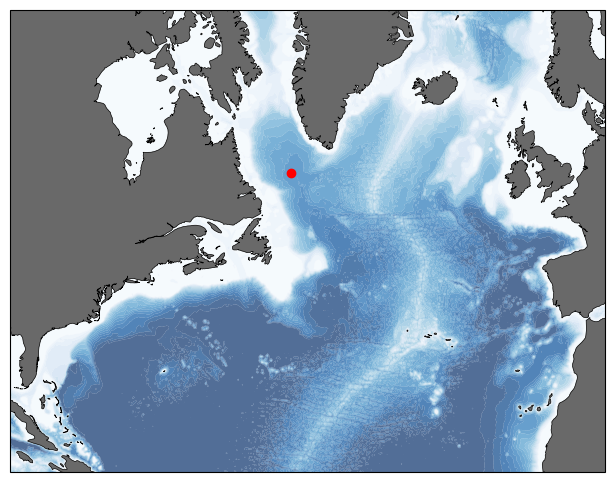

In [4]:
# Make map figure
fig, ax = show_map(lon, lat)

Load `highFrequencyOutput`

In [5]:
# Define run and load example results file
dt = 1800
resultspath = '/pscratch/sd/b/bmoorema/E3SMv3/v3.LR.GMPAS-JRA1p5.pm-cpu/tests/S_1x10_ndays/run/'
filename = 'v3.LR.GMPAS-JRA1p5.pm-cpu.mpaso.hist.am.highFrequencyOutput.0001-01-01_00.00.00.nc'
ds = xr.open_dataset(os.path.join(resultspath, filename))

Define budget variables

In [6]:
# Budget variables
varNames = {
    'temperature': {
        'Total'     : 'temperatureTend',
        'HorzAdv'   : 'temperatureHorizontalAdvectionTendency',
        'VertAdv'   : 'temperatureVerticalAdvectionTendency',
        'HorzMix'   : 'temperatureHorMixTendency',
        'VertMix'   : 'temperatureVertMixTendency',
        'Surf'      : 'temperatureSurfaceFluxTendency',
        'Nonlocal'  : 'temperatureNonLocalTendency',
        'Frazil'    : 'frazilTemperatureTendency',
        'ShortWave' : 'temperatureShortWaveTendency',
    },
    'salinity': {
        'Total'     : 'salinityTend',
        'HorzAdvS'  : 'salinityHorizontalAdvectionTendency',
        'VertAdvS'  : 'salinityVerticalAdvectionTendency',
        'HorzMixS'  : 'salinityHorMixTendency',
        'VertMixS'  : 'salinityVertMixTendency',
        'SurfS'     : 'salinitySurfaceFluxTendency',
        'NonlocalS' : 'salinityNonLocalTendency',
        'FrazilS'   : 'frazilSalinityTendency',
    },
    'layerThickness': {
        'Total'     : 'tendLayerThickness',
    }
}

Temperature budget variables

In [7]:
# Temperature budget
for varName, fullName in varNames['temperature'].items():
    attrs = ds[fullName].attrs
    long_name, units = attrs['long_name'], attrs['units']
    print(f'{varName:10s} {long_name:73s} {units}')

Total      time tendency of potential temperature measured as change in degrees times layerThickness per second C m s^-1
HorzAdv    thickness weighted potential temperature tendency due to horizontal advection m C s^-1
VertAdv    thickness weighted potential temperature tendency due to vertical advection m C s^-1
HorzMix    thickness weighted potential temperature tendency due to horizontal mixing (including part of Redi) m C s^-1
VertMix    thickness weighted potential temperature tendency due to vertical mixing  m C s^-1
Surf       thickness weighted potential temperature tendency due to surface fluxes   m C s^-1
Nonlocal   thickness weighted potential temperature tendency due to kpp non-local flux m C s^-1
Frazil     temperature tendency due to frazil processes                              m C s^-1
ShortWave  thickness weighted potential temperature tendency due to penetrating shortwave m C s^-1


Salinity budget variables

In [8]:
# Salinity budget
for varName, fullName in varNames['salinity'].items():
    attrs = ds[fullName].attrs
    long_name, units = attrs['long_name'], attrs['units']
    print(f'{varName:10s} {long_name:60s} {units}')

Total      time tendency of salinity measured as change in practical salinity units times layerThickness per second m 1.e-3 s^-1
HorzAdvS   thickness weighted salinity tendency due to horizontal advection m 1.e-3 s^-1
VertAdvS   thickness weighted salinity tendency due to vertical advection m 1.e-3 s^-1
HorzMixS   thickness weighted salinity tendency due to horizontal mixing (including part of Redi) m 1.e-3 s^-1
VertMixS   thickness weighted salinity tendency due to vertical mixing  m 1.e-3 s^-1
SurfS      thickness weighted salinity tendency due to surface fluxes   m 1.e-3 s^-1
NonlocalS  thickness weighted salinity tendency due to kpp non-local flux m 1.e-3 s^-1
FrazilS    salinity tendency due to frazil processes                    m 1.e-3 s^-1


***

### Calculate budget closure

Calculate closure residuals based on LHS, RHS_total, and RHS_terms (residual is scaled by resting layerThickness).

In [10]:
# Get layerThickness
layerThickness = ds.layerThickness[:, nCell, :].values

# Initialize LHS and RHS
RES = {'LHS-RHS_total': {}, 'RHS_total-RHS_terms': {}}

# Loop through variables
for varName, tendencies in varNames.items():

    # Get LHS
    array = ds[varName][:, nCell, :].values
    if varName != 'layerThickness':
        array = array * layerThickness
    LHS = np.diff(array, axis=0)

    # Get RHS
    RHS_terms = []
    for tendName, tendNameFull in tendencies.items():
        array = ds[tendNameFull][1:, nCell, :].values
        if tendName == 'Total':
            RHS_total = array * dt
        else:
            RHS_terms.append(array)
    RHS_terms = sum(RHS_terms) * dt

    # Get residuals
    RES['LHS-RHS_total'][varName] = (LHS - RHS_total) / layerThickness0
    if varName != 'layerThickness':
        RES['RHS_total-RHS_terms'][varName] = (RHS_total - RHS_terms) / layerThickness0

Plot LHS - RHS_total

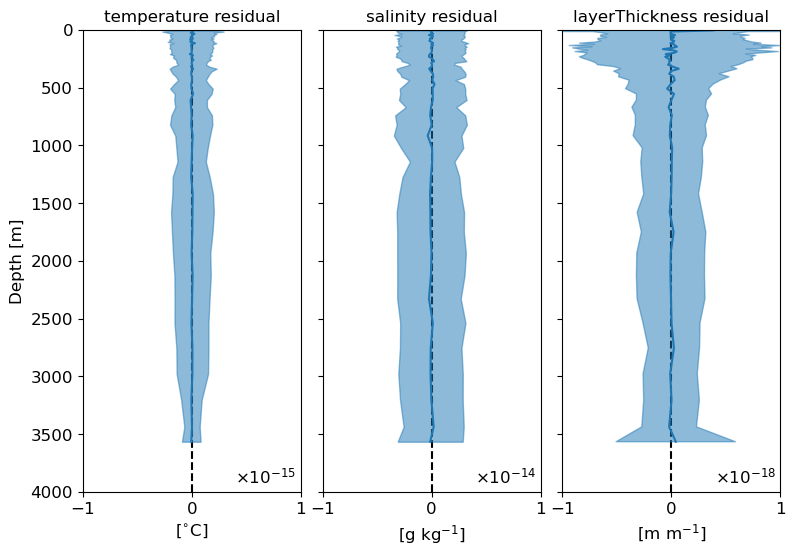

In [11]:
# Plot LHS-RHS_total
fig, axs = plot_residuals(RES['LHS-RHS_total'], depth, scales=[15, 14, 18])

Plot RHS_total - RHS_terms

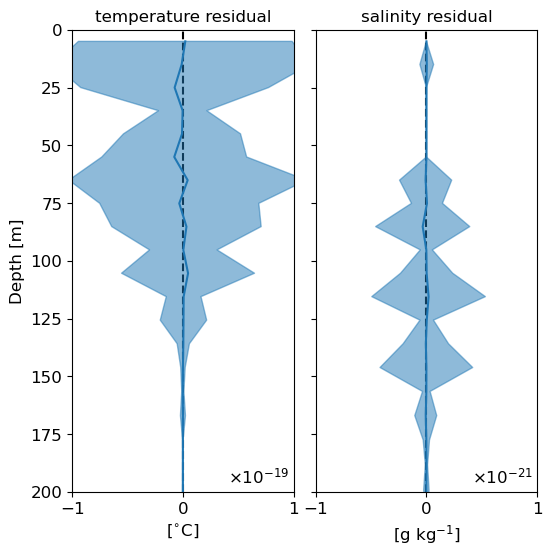

In [12]:
# Plot RHS_total-RHS_terms
fig, axs = plot_residuals(RES['RHS_total-RHS_terms'], depth, scales=[19, 21], ylim=[200, 0])